In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import json

In [3]:
def Sigmoid(x, mean=0, std=1):
    return 1 / (1 + np.exp(-x))

def trunc(x, f):
    return np.floor(x * 2**(-f))

def real_to_fixed(x, f):
    x_fixed = np.floor(x * 2**f)
    return x_fixed

def fixed_to_real(x, f):
    return x / 2**f

def lut_gen(func, a, b, f, q):
    """Create a Look Up Table for func.
    a: lower boundary
    b: upper boundary
    f: precision
    q: LUT size
    """
    x = np.linspace(a, b-2**-q, (b-a)*2**q)
    value = real_to_fixed(func(x), f)
    return value

def lut_eval(x, T):
    y = x.copy()
    for i, e in enumerate(x):
        y[i] =  T[int(e)]
    return y

LUT Size: 512
max(diff)=16.0
sum(diff)/len(diff)=3.79522705078125


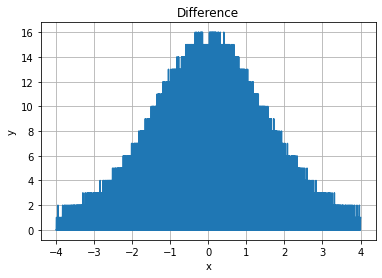

In [22]:
a = -4
b = 4
f = 12
q = 6

# Quantized LUT JSON file generation
## LSB 
lut = lut_gen(Sigmoid, a, b, f, q)
lut_dict = {str(index[0]): int(value) & 0xFF for index, value in np.ndenumerate(lut)}
with open("lut16_quantized_lsb.json", 'w') as fout:
    json_dumps_str = json.dumps(lut_dict, indent=4)
    print(json_dumps_str, file=fout)
## MSB 
lut_dict = {str(index[0]): (int(value) >> 8) & 0xFF for index, value in np.ndenumerate(lut)}
with open("lut16_quantized_msb.json", 'w') as fout:
    json_dumps_str = json.dumps(lut_dict, indent=4)
    print(json_dumps_str, file=fout)

print(f"LUT Size: {len(lut)}")

x = np.linspace(a, b-2**-f, (b-a)*2**f)
y = Sigmoid(x)
y_fixed = real_to_fixed(y, f)

x_fixed = real_to_fixed(x, f)
x_trunced = trunc(x_fixed, f - q)
x_shifted = x_trunced - np.min(x_trunced)
y_lut = lut_eval(x_shifted, lut)

diff = abs(y_fixed - y_lut)
print(f"{max(diff)=}")
print(f"{sum(diff)/len(diff)=}")
plt.plot(x, diff)
plt.title("Difference")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

DWT LUT Size: 256
max(diff)=16.0
sum(diff)/len(diff)=3.8551025390625


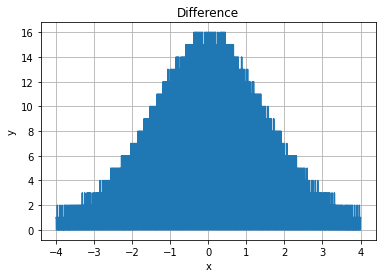

In [24]:
n = 7

coeffs = pywt.wavedec(y, 'haar', level=n)
# Set detail coefficients at level m and higher to zero
# for i in range(1, n+1):
#     coeffs[i] = np.zeros_like(coeffs[i])
# Reconstruct the approximation
print(f"DWT LUT Size: {len(coeffs[0])}")

# Generate DWT LUT Entries
fixed_lut = real_to_fixed(coeffs[0], f)

lut_dict = {str(index[0]): int(value) & 0xFF for index, value in np.ndenumerate(fixed_lut)}
with open("lut16_dwt_lsb.json", 'w') as fout:
    json_dumps_str = json.dumps(lut_dict, indent=4)
    print(json_dumps_str, file=fout)
## MSB 
lut_dict = {str(index[0]): (int(value) >> 8) & 0xFF for index, value in np.ndenumerate(fixed_lut)}
with open("lut16_dwt_msb.json", 'w') as fout:
    json_dumps_str = json.dumps(lut_dict, indent=4)
    print(json_dumps_str, file=fout)


y_hat = real_to_fixed(pywt.waverec(coeffs, 'haar'), f)

diff = abs(y_fixed - y_hat)
print(f"{max(diff)=}")
print(f"{sum(diff)/len(diff)=}")
plt.plot(x, diff)
plt.title("Difference")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
plt.plot(x, y_lut);

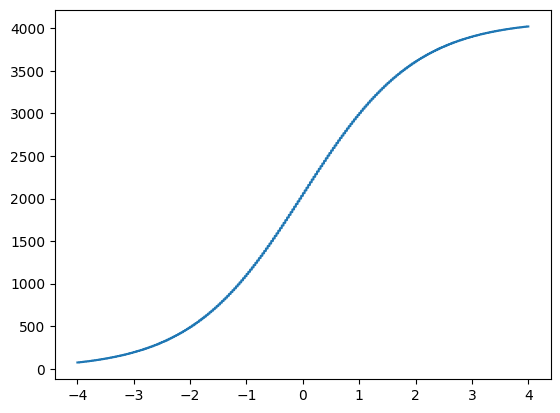

In [74]:
plt.plot(x, y_hat);